## Optimal Q_tau* test

junix --filepath ./Test.ipynb --output_dir ./results/intermediate_curves

In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt

import math
from utils import *

In [2]:
# Test with tau=0.9
nS = 8
nA = 2
seed = 3231
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.9
status_step = 500
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma, seed)
results = []
taus = [0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.090, 0.080, 0.070, 0.060, 0.050, 0.040, 0.030, 0.020, 0.010]

In [3]:
"""taus = np.flip(np.linspace(0, 1, num=100))
"""

'taus = np.flip(np.linspace(0, 1, num=100))\nprint(taus)'

In [4]:
def compute_tau_prime(A_hat, gamma, tau, Delta_Q):
    return tau - A_hat*(1-gamma)/(4*gamma**2*Delta_Q)

def compute_performance_improvement_lower_bound(A_hat, gamma, Delta_Q, tau:float, tau_1:float):
    return A_hat*(tau-tau_1)/(1-gamma) - 2*gamma**2*Delta_Q*(tau-tau_1)**2/(2*(1-gamma)**2)



In [7]:
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    
    Q_star_tau = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat_tau, tmdp.reward, 1e-4, tmdp.gamma)

    d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.gamma)
    # Compute the gamma discounted state distribution
    delta = compute_delta(d, get_policy(Q_star_tau))
    # Compute the state value function
    V_star_tau = get_value_function(Q_star_tau) 
    # Compute the expected reward when picking action a in state s
    r_s_a = compute_r_s_a(nS, nA, tmdp.P_mat_tau, tmdp.reward)
    # Compute the state action next-state value function U_tau(s,a,s') = R(s,a) + \gamma*V_tau(s')
    U_star_tau = compute_state_action_nextstate_value_function(nS, nA, r_s_a, tmdp.gamma, V_star_tau)
    # Rebuild Q using U as Q_tau(s,a) = \sum{s' \in S}P_tau(s'|s,a)*U_tau(s,a,s')
    Q_t = rebuild_Q_from_U(tmdp.P_mat_tau, U_star_tau)


    # Compute the relative model advantage function hat \hat{A}_{tau, mu}(s,a)
    A_tau_hat = compute_relative_model_advantage_function_hat(tmdp.P_mat, tmdp.xi, U_star_tau)
    # Compute the discounted distribution relative model advantage function hat \hat{A}_{tau, mu}
    A_hat = compute_discounted_distribution_relative_model_advantage_function_hat(A_tau_hat, delta)
    # The dissimilarity term D = D_e * gamma * D_inf is upperbounded by 4*gamma+(tau - tau_1)
    # Compute Delta Q_tau as the superior among the difference of the L_1 norm of elements of Q_tau
    d_q = get_sup_difference_q(Q_star_tau)
    
    # Compute the performance improvement lower bound when moving to tau=0
    l_b = compute_performance_improvement_lower_bound(A_hat, tmdp.gamma, d_q, tmdp.tau, 0.0)
    
    
    tau_1 = compute_tau_prime(A_hat, tmdp.gamma, tmdp.tau, d_q)
    tmdp_1 = tmdp = TMDP(river, xi, tau_1, gamma)
    print(tmdp.tau)
   
    print(tmdp_1.tau)
    print(tmdp.tau - A_hat*(1-gamma)/(4*gamma**2*d_q))

    J_star_tau = get_expected_avg_reward(tmdp.P_mat_tau, get_policy(Q_star_tau), tmdp.reward, tmdp.gamma, tmdp.mu)
    J_0 = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star_tau), tmdp.reward, tmdp.gamma, tmdp.mu)
    J_1 = get_expected_avg_reward(tmdp_1.P_mat_tau, get_policy(Q_star_tau), tmdp_1.reward, tmdp_1.gamma, tmdp_1.mu)

    print(tmdp.tau)
   

    print("Moving from {} to {}".format(tmdp.tau, 0.))
    print("Theoretical lb on performance improvement: {}, Empirical one: {}\n".format(l_b, J_0-J_star_tau))

    print("Moving from {} to {}".format(tmdp.tau, tmdp_1.tau))
    l_b_1 = compute_performance_improvement_lower_bound(A_hat, tmdp.gamma, d_q, tmdp.tau, tau_1)
    opt_lb = compute_optimal_lower_bound(A_hat, gamma, d_q)
    print("Theoretical lb on performance improvement: {}, Empirical one: {}".format(l_b_1, J_1-J_star_tau))
    print("\nThe lower bound for tau' is: {}".format(opt_lb))
    print("\n\n")
    
    results.append({"Q": Q_star_tau, "tau":tmdp.tau, "J":J_star_tau, "J_0":J_0, "policy":get_policy(Q_star_tau), "l_b":l_b})

-6.077125210579455
0.901278344194068
0.901278344194068
0.9025566883881361
0.901278344194068
Moving from 0.901278344194068 to 0.0
Theoretical lb on performance improvement: -9681.3491455737, Empirical one: 142.99603554120984

Moving from 0.901278344194068 to 0.901278344194068
Theoretical lb on performance improvement: -0.0, Empirical one: 0.0

The lower bound for tau' is: 0.038843288647843185



-6.472634965393808
0.801171633532003
0.801171633532003
0.802343267064006
0.801171633532003
Moving from 0.801171633532003 to 0.0
Theoretical lb on performance improvement: -8890.906678087747, Empirical one: 127.89986173188274

Moving from 0.801171633532003 to 0.801171633532003
Theoretical lb on performance improvement: -0.0, Empirical one: 0.0

The lower bound for tau' is: 0.03791778082935252



-6.693576913432643
0.7010483678718508
0.7010483678718508
0.7020967357437016
0.7010483678718508
Moving from 0.7010483678718508 to 0.0
Theoretical lb on performance improvement: -7868.185641056562, Empirica

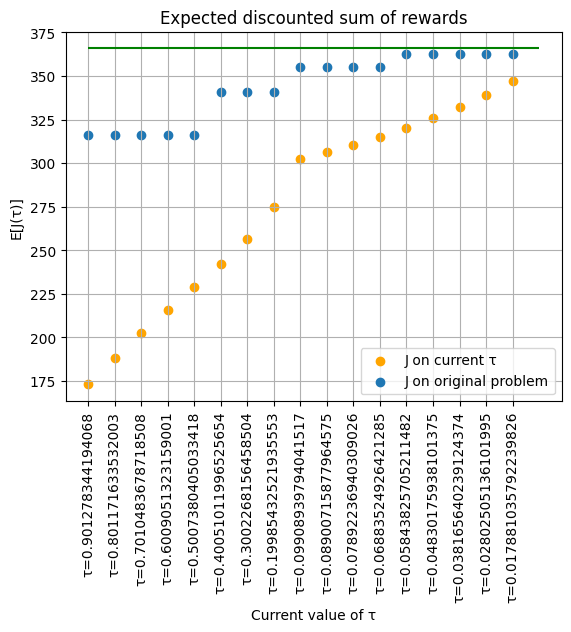

In [ ]:
x = np.array([])
y = np.array([])
z = np.array([])
for i, res in enumerate(results):
    if i < len(results)-1:
        y = np.append(y, res['J'])
        label = "τ="+str(res['tau'])
        x = np.append(x, label)
        z = np.append(z, res['J_0'])
x_map = np.array([i for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(x, y, c='orange', label='J on current τ')
plt.scatter(x, z, label='J on original problem')
plt.xticks(x_map, x)

plt.hlines(y=res['J_0'], xmin=0, xmax=len(x), colors='g')
plt.xlabel("Current value of τ")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)
plt.legend(loc="lower right")




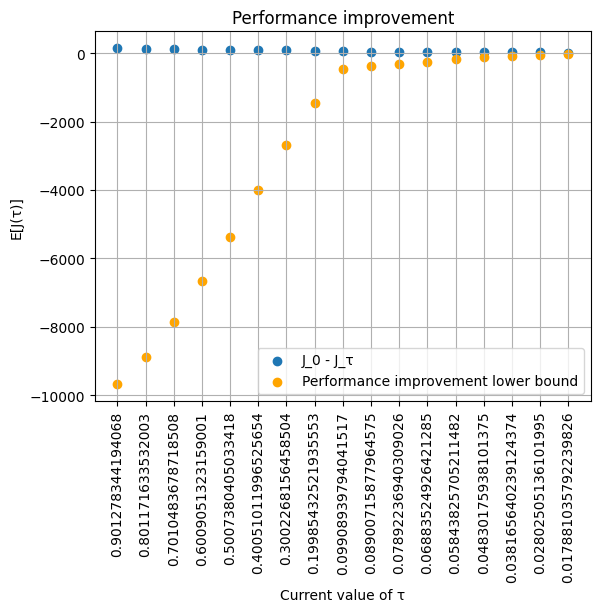

In [ ]:
x = np.array([])
y = np.array([])
z = np.array([])
for i, res in enumerate(results):
    if i < len(results)-1:
        y = np.append(y, res['J_0'] - res['J'])
        label = str(res['tau'])
        x = np.append(x, label)
        z = np.append(z, res['l_b'])
x_map = np.array([i for i in range(len(x))])

plt.scatter(x, y, label='J_0 - J_τ')
plt.scatter(x, z,  c='orange', label='Performance improvement lower bound')
plt.xticks(x_map, x)

plt.xlabel("Current value of τ")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Performance improvement")
plt.grid(visible=True)
plt.legend(loc="lower right")
